In [1]:
import pandas as pd

In [4]:
df = pd.read_csv("/kaggle/input/higgsbosson/training.csv")

In [7]:
df.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


In [8]:
df.shape

(250000, 33)

In [10]:
X = df.drop(columns = ["Label", "EventId", "Weight"])
y = df["Label"]

In [12]:
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [18]:
train.shape, test.shape

((200000, 31), (50000, 31))

def anova(df, feature, label):
    import pandas as pd
    import numpy as np
    from scipy import stats
    
    groups = df[feature].unique()
    df_grouped = df.groupby(feature)
    group_labels = []
    for g in groups:
        g_list = df_grouped.get_group(g)
        group_labels.append(g_list[label])
        
    return stats.f_oneway(*group_labels)    


def Chisquare(df, feature, label):
    import pandas as pd
    import scipy.stats
    ct = pd.crosstab(index = df[feature], columns=df[label])
    chi2, p,dof,_ = scipy.stats.chi2_contingency([ct.iloc[0].values, ct.iloc[1].values])
    return chi2,p
    
    
def T(df, feature, label): 
    import pandas as pd
    import numpy as np
    from scipy import stats
    partial_high_school = df[df[feature] == (df[feature].unique()[0])]
    high_school = df[df[feature] == (df[feature].unique()[1])]
    t, p = stats.ttest_ind(partial_high_school[label],high_school[label] )
    return t,p

def bivstats(df, label):
    from scipy import stats
    import pandas as pd
    import numpy as np
    
#   Create an empty Dataframe to store the output
    output_df = pd.DataFrame(columns = ['Stat_r', '+/-_F', 'Effect_size_X^2', 'p-value'])
    
    for col in df:
        if not col == label:
            if df[col].isnull().sum() == 0:
                if pd.api.types.is_numeric_dtype(df[col]) and pd.api.types.is_numeric_dtype(df[label]):
                    r, p = stats.pearsonr(df[label], df[col])
                    if r > 0:
                        output_df.loc[col] = ['r', '+', abs(round(r, 3)), round(p, 6)]
                    else:
                        output_df.loc[col] = ['r', '-', abs(round(r, 3)), round(p, 6)]
                elif((pd.api.types.is_numeric_dtype(df[label])) and not (pd.api.types.is_numeric_dtype(df[col])) and (df[col].nunique()==2)):
                        t, p = T(df[[col,label]],col,label)
                        output_df.loc[col] = ['t','',round(t,3),round(p,6) ]
                elif((pd.api.types.is_numeric_dtype(df[col])) and not (pd.api.types.is_numeric_dtype(df[label])) and (df[label].nunique()==2)):
                        t, p = T(df[[col, label]],label,col)
                        output_df.loc[col] = ['t','',round(t,3),round(p,6) ]
                elif (pd.api.types.is_numeric_dtype(df[label]) and not pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique()!=2):
                    F, p = anova(df[[col, label]],col,label)
                    output_df.loc[col] = ['F','',round(F,3),round(p,6) ]
                elif  (pd.api.types.is_numeric_dtype(df[col]) and not pd.api.types.is_numeric_dtype(df[label])):
                    F, p = anova(df[[col, label]],label,col)
                    output_df.loc[col] = ['F','',round(F,3),round(p,6) ]
                elif (not pd.api.types.is_numeric_dtype(df[label]) and not pd.api.types.is_numeric_dtype(df[col]) ):
                    try:
                        X, p = Chisquare(df[[col, label]],col,label)
                        output_df.loc[col] = ['X','',round(X,3),round(p,6) ]
                    except:
                        pass
            else:
                output_df.loc[col] = [np.nan, np.nan, np.nan, 'Nulls']
    
    return output_df.sort_values(by=['Effect_size_X^2','Stat_r'],ascending=[False,False])X = data_train.drop(['Label'], axis = 1)
y = data_train['Label']# EDA

In [14]:
def unistats(df):
    import pandas as pd
    output_df = pd.DataFrame(columns=['Count', 'Missing', 'Unique', 'Dtype', 'Numeric','Mode', 'Mean', 'Min', '25%', 'Median', '75%', 'Max', 'Std', 'Skew', 'Kurt'])
    
    for col in df:
        if pd.api.types.is_numeric_dtype(df[col]):
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(),
                                  df[col].dtype, pd.api.types.is_numeric_dtype(df[col]), df[col].mode().values[0], df[col].mean(), df[col].min(),
                                  df[col].quantile(0.25), df[col].median(), df[col].quantile(0.75), 
                                  df[col].max(), df[col].std(), df[col].skew(), df[col].kurt()]
        else:
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(),
                                  df[col].dtype, pd.api.types.is_numeric_dtype(df[col]), df[col].mode().values[0], '-', '-', 
                                  '-', '-', '-',
                                  '-', '-', '-', '-']
            
    return output_df.sort_values(by = ['Numeric', 'Skew', 'Unique'], ascending = False)

In [15]:
unistats(train)

,Count,Missing,Unique,Dtype,Numeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
DER_pt_tot,200000,0,54388,float64,True,1.503,18.910655,0.0,2.832,12.2815,27.58825,2834.999,22.4312,12.303393,1255.306251
PRI_met,200000,0,80786,float64,True,31.252,41.704673,0.109,21.362,34.784,51.862,2842.617,33.069248,5.82219,274.348984
DER_mass_vis,200000,0,91020,float64,True,70.412,81.167008,6.329,59.387,73.752,92.25225,1349.351,40.710621,3.802638,36.786863
PRI_tau_pt,200000,0,55159,float64,True,21.134,38.712854,20.0,24.599,31.7885,45.006,764.408,22.425758,3.795296,32.108913
PRI_lep_pt,200000,0,57415,float64,True,28.855,46.668882,26.0,32.381,40.5205,53.409,560.271,21.998823,3.183616,20.92779
DER_pt_h,200000,0,102264,float64,True,0.0,57.868531,0.0,13.96175,38.4215,79.05,2834.999,63.719418,2.616364,25.532192
DER_pt_ratio_lep_tau,200000,0,5634,float64,True,0.901,1.437198,0.047,0.884,1.28,1.776,19.672,0.840834,2.563867,17.186559
PRI_jet_all_pt,200000,0,87980,float64,True,0.0,72.942732,-0.0,0.0,40.4035,110.00525,1633.433,97.876731,2.37921,9.959321
DER_sum_pt,200000,0,134865,float64,True,68.481,158.324468,46.229,77.457,120.465,200.49625,1852.462,115.54094,2.314523,8.828094
PRI_met_sumet,200000,0,152610,float64,True,151.0,209.626414,13.678,122.98,179.5235,263.33125,2003.976,126.274345,1.84703,6.300923


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 83187 to 245091
Data columns (total 31 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   DER_mass_MMC                 200000 non-null  float64
 1   DER_mass_transverse_met_lep  200000 non-null  float64
 2   DER_mass_vis                 200000 non-null  float64
 3   DER_pt_h                     200000 non-null  float64
 4   DER_deltaeta_jet_jet         200000 non-null  float64
 5   DER_mass_jet_jet             200000 non-null  float64
 6   DER_prodeta_jet_jet          200000 non-null  float64
 7   DER_deltar_tau_lep           200000 non-null  float64
 8   DER_pt_tot                   200000 non-null  float64
 9   DER_sum_pt                   200000 non-null  float64
 10  DER_pt_ratio_lep_tau         200000 non-null  float64
 11  DER_met_phi_centrality       200000 non-null  float64
 12  DER_lep_eta_centrality       200000 non-null  float64


In [19]:
def anova(df, feature, label):
    import pandas as pd
    import numpy as np
    from scipy import stats
    
    groups = df[feature].unique()
    df_grouped = df.groupby(feature)
    group_labels = []
    for g in groups:
        g_list = df_grouped.get_group(g)
        group_labels.append(g_list[label])
        
    return stats.f_oneway(*group_labels)    


def Chisquare(df, feature, label):
    import pandas as pd
    import scipy.stats
    ct = pd.crosstab(index = df[feature], columns=df[label])
    chi2, p,dof,_ = scipy.stats.chi2_contingency([ct.iloc[0].values, ct.iloc[1].values])
    return chi2,p
    
    
def T(df, feature, label): 
    import pandas as pd
    import numpy as np
    from scipy import stats
    partial_high_school = df[df[feature] == (df[feature].unique()[0])]
    high_school = df[df[feature] == (df[feature].unique()[1])]
    t, p = stats.ttest_ind(partial_high_school[label],high_school[label] )
    return t,p

def bivstats(df, label):
    from scipy import stats
    import pandas as pd
    import numpy as np
    
#   Create an empty Dataframe to store the output
    output_df = pd.DataFrame(columns = ['Stat_r', '+/-_F', 'Effect_size_X^2', 'p-value'])
    
    for col in df:
        if not col == label:
            if df[col].isnull().sum() == 0:
                if pd.api.types.is_numeric_dtype(df[col]) and pd.api.types.is_numeric_dtype(df[label]):
                    r, p = stats.pearsonr(df[label], df[col])
                    if r > 0:
                        output_df.loc[col] = ['r', '+', abs(round(r, 3)), round(p, 6)]
                    else:
                        output_df.loc[col] = ['r', '-', abs(round(r, 3)), round(p, 6)]
                elif((pd.api.types.is_numeric_dtype(df[label])) and not (pd.api.types.is_numeric_dtype(df[col])) and (df[col].nunique()==2)):
                        t, p = T(df[[col,label]],col,label)
                        output_df.loc[col] = ['t','',round(t,3),round(p,6) ]
                elif((pd.api.types.is_numeric_dtype(df[col])) and not (pd.api.types.is_numeric_dtype(df[label])) and (df[label].nunique()==2)):
                        t, p = T(df[[col, label]],label,col)
                        output_df.loc[col] = ['t','',round(t,3),round(p,6) ]
                elif (pd.api.types.is_numeric_dtype(df[label]) and not pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique()!=2):
                    F, p = anova(df[[col, label]],col,label)
                    output_df.loc[col] = ['F','',round(F,3),round(p,6) ]
                elif  (pd.api.types.is_numeric_dtype(df[col]) and not pd.api.types.is_numeric_dtype(df[label])):
                    F, p = anova(df[[col, label]],label,col)
                    output_df.loc[col] = ['F','',round(F,3),round(p,6) ]
                elif (not pd.api.types.is_numeric_dtype(df[label]) and not pd.api.types.is_numeric_dtype(df[col]) ):
                    try:
                        X, p = Chisquare(df[[col, label]],col,label)
                        output_df.loc[col] = ['X','',round(X,3),round(p,6) ]
                    except:
                        pass
            else:
                output_df.loc[col] = [np.nan, np.nan, np.nan, 'Nulls']
    
    return output_df.sort_values(by=['Effect_size_X^2','Stat_r'],ascending=[False,False])

In [21]:
bivstats(train, 'Label')

,Stat_r,+/-_F,Effect_size_X^2,p-value
DER_mass_transverse_met_lep,t,,167.689,0.000000
DER_pt_ratio_lep_tau,t,,88.876,0.000000
PRI_lep_pt,t,,13.844,0.000000
DER_pt_tot,t,,6.485,0.000000
DER_mass_vis,t,,6.269,0.000000
PRI_tau_phi,t,,3.117,0.001826
PRI_tau_eta,t,,0.664,0.506915
PRI_lep_eta,t,,-0.276,0.782591
PRI_lep_phi,t,,-2.641,0.008268
PRI_met_phi,t,,-3.399,0.000678


In [25]:
import  matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipykernel_33/3932517491.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), vmin = -1, vmax = 1, annot = True, cmap = plt.cm.CMRmap_r)


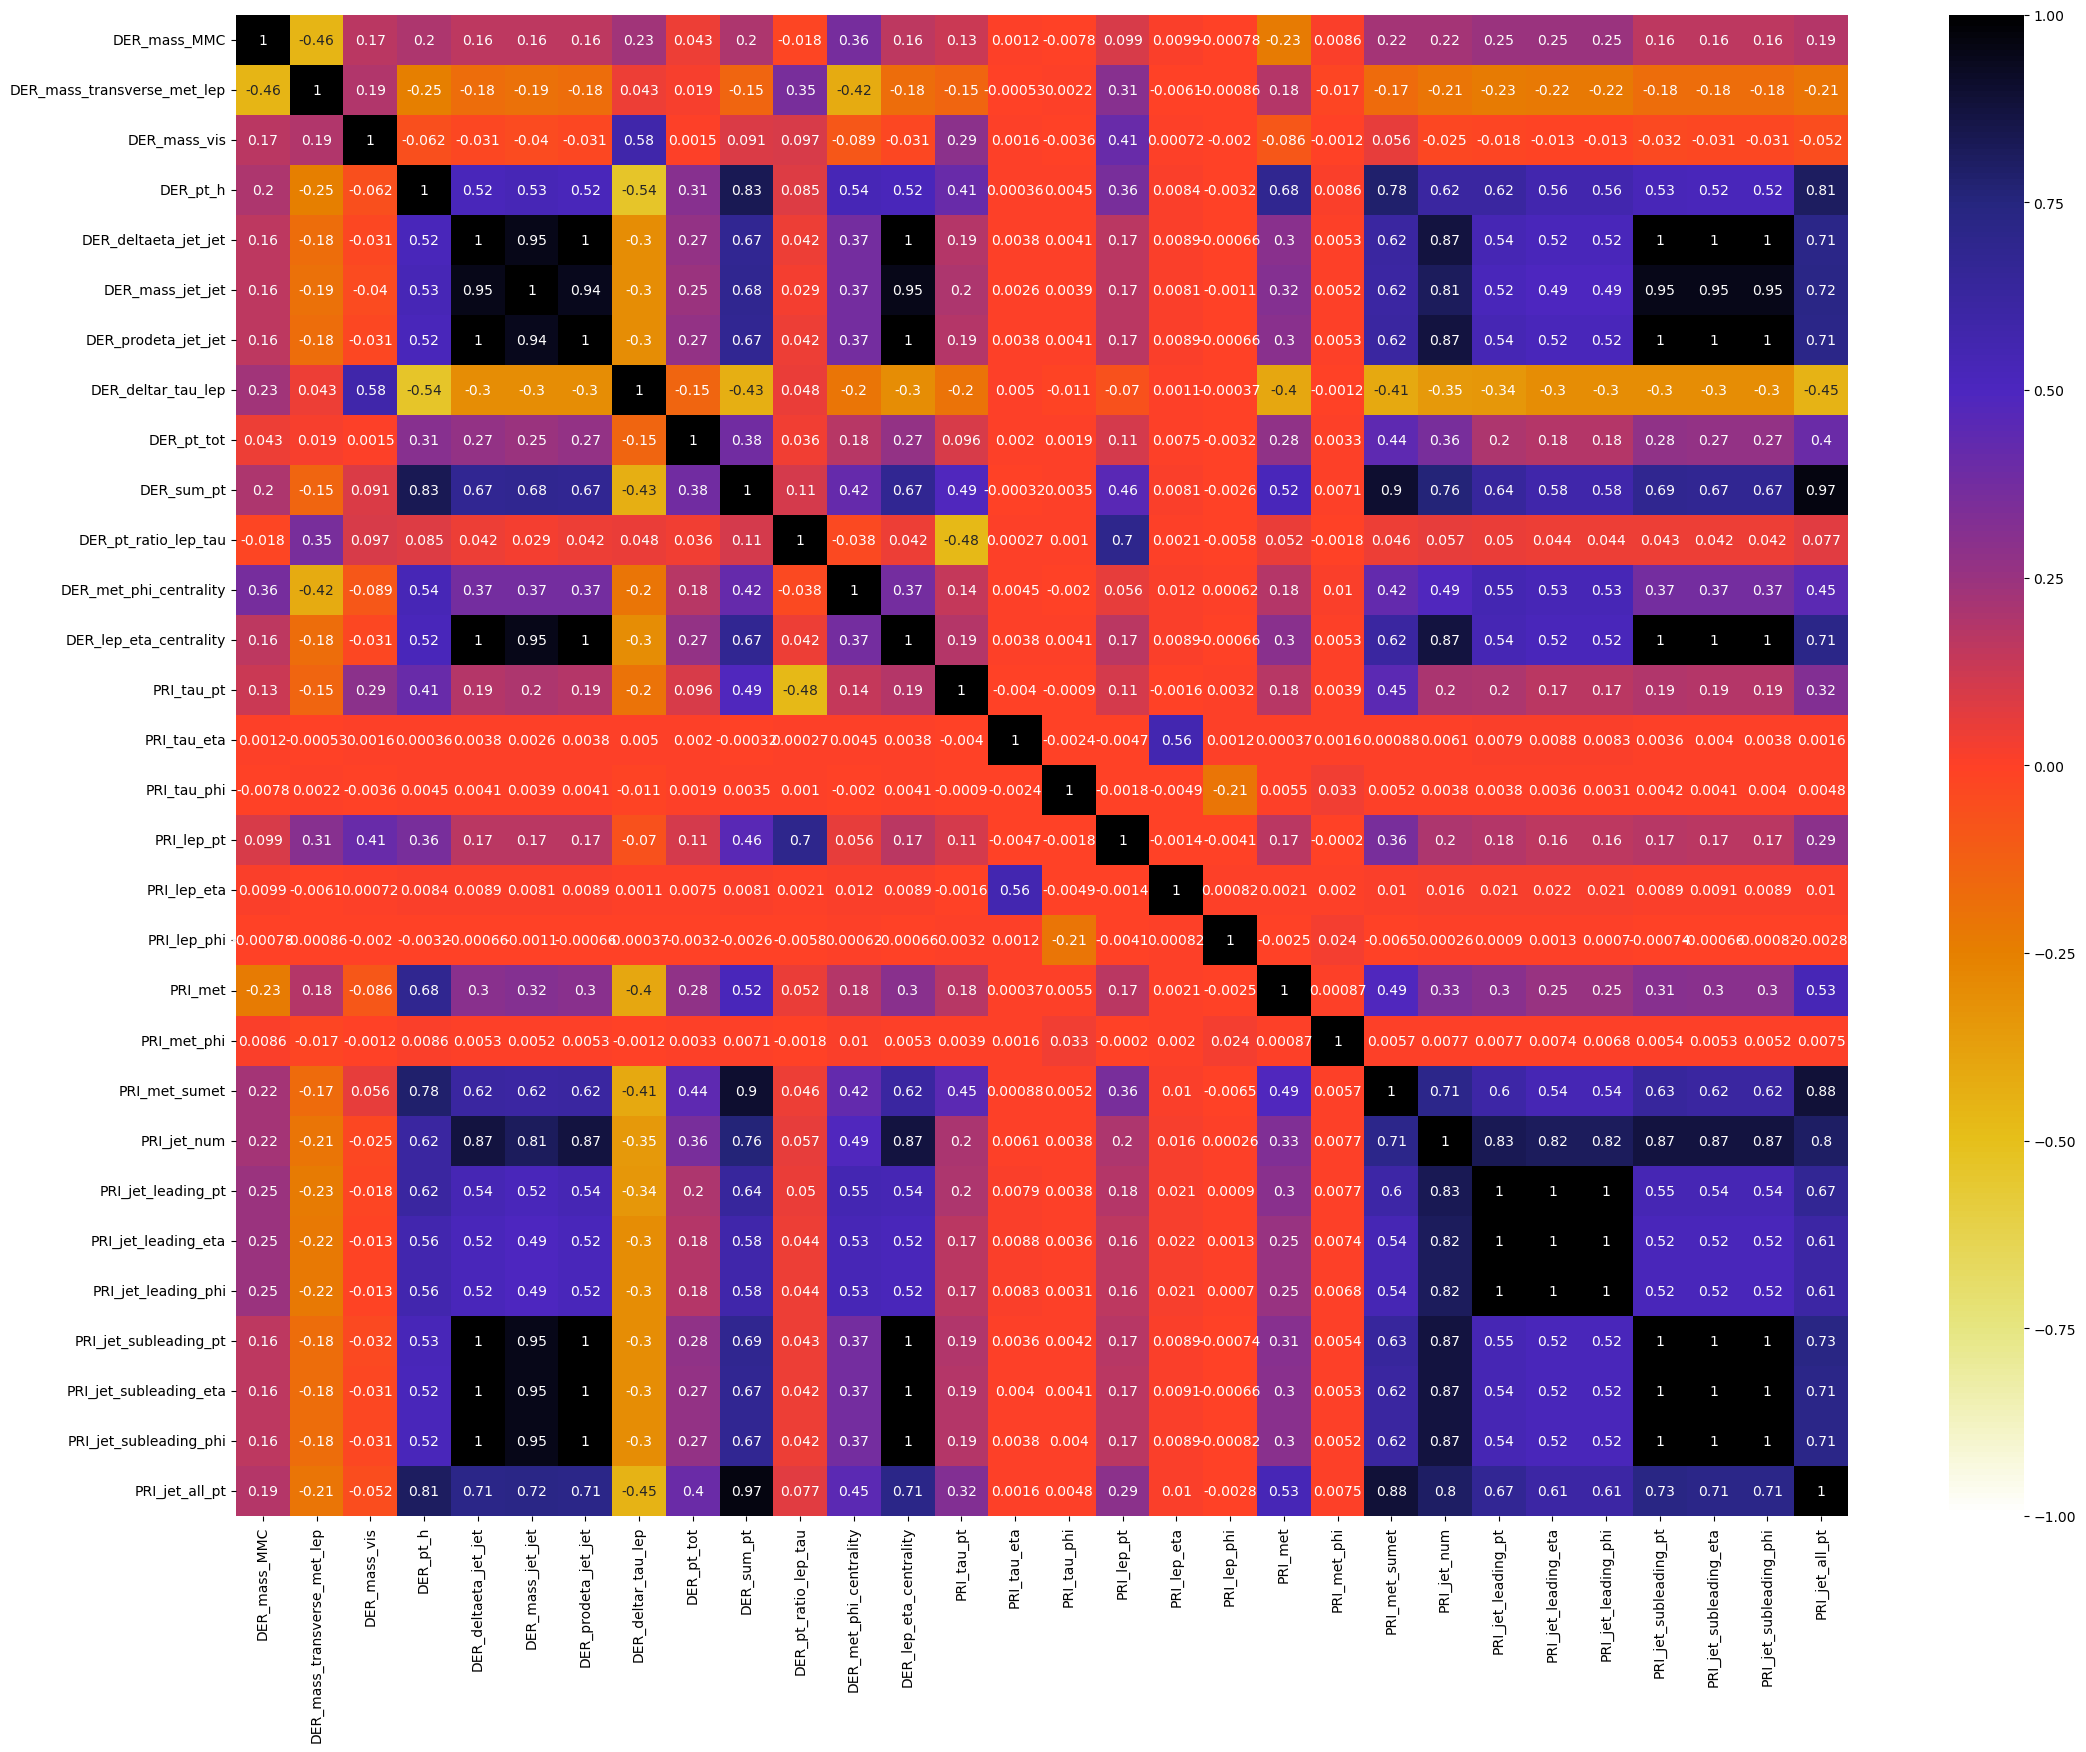

In [26]:
# Correlation heatmap of float features for the training set
plt.figure(figsize = (26, 19.5))
sns.heatmap(train.corr(), vmin = -1, vmax = 1, annot = True, cmap = plt.cm.CMRmap_r)
plt.show()

In [28]:
train1 = train.fillna(train.median)
test1 = test.fillna(train.median)

In [29]:
train1.dtypes

DER_mass_MMC                   float64
DER_mass_transverse_met_lep    float64
DER_mass_vis                   float64
DER_pt_h                       float64
DER_deltaeta_jet_jet           float64
DER_mass_jet_jet               float64
DER_prodeta_jet_jet            float64
DER_deltar_tau_lep             float64
DER_pt_tot                     float64
DER_sum_pt                     float64
DER_pt_ratio_lep_tau           float64
DER_met_phi_centrality         float64
DER_lep_eta_centrality         float64
PRI_tau_pt                     float64
PRI_tau_eta                    float64
PRI_tau_phi                    float64
PRI_lep_pt                     float64
PRI_lep_eta                    float64
PRI_lep_phi                    float64
PRI_met                        float64
PRI_met_phi                    float64
PRI_met_sumet                  float64
PRI_jet_num                      int64
PRI_jet_leading_pt             float64
PRI_jet_leading_eta            float64
PRI_jet_leading_phi      

In [30]:
X = train1.drop(['Label'], axis = 1)
y = train1['Label']

In [43]:
Xtest = test1.drop(['Label'], axis = 1)
ytest = test1['Label']

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [44]:
Xtest = scaler.transform(Xtest)

In [34]:
y = y.map({'b':0,'s':1})

In [45]:
ytest = ytest.map({'b':0,'s':1})

In [41]:
# keras neural network

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf

model = Sequential()

model.add(Dense(12, input_dim=30, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')

In [42]:
model.fit(X,y,epochs=20,callbacks=[callback])

Epoch 1/20
6250/6250 [==============================] - 15s 2ms/step - loss: 0.4960 - accuracy: 0.7579
Epoch 2/20
6250/6250 [==============================] - 13s 2ms/step - loss: 0.4411 - accuracy: 0.7969
Epoch 3/20
6250/6250 [==============================] - 13s 2ms/step - loss: 0.4337 - accuracy: 0.8022
Epoch 4/20
6250/6250 [==============================] - 13s 2ms/step - loss: 0.4298 - accuracy: 0.8050
Epoch 5/20
6250/6250 [==============================] - 14s 2ms/step - loss: 0.4270 - accuracy: 0.8064
Epoch 6/20
6250/6250 [==============================] - 14s 2ms/step - loss: 0.4270 - accuracy: 0.8065
Epoch 7/20
6250/6250 [==============================] - 13s 2ms/step - loss: 0.4260 - accuracy: 0.8073
Epoch 8/20
6250/6250 [==============================] - 13s 2ms/step - loss: 0.4254 - accuracy: 0.8070
Epoch 9/20
6250/6250 [==============================] - 13s 2ms/step - loss: 0.4247 - accuracy: 0.8076
Epoch 10/20
6250/6250 [==============================] - 14s 2ms/step - l

In [47]:
Xpred = model.predict(Xtest)

1563/1563 [==============================] - 2s 1ms/step


<Axes: ylabel='Count'>

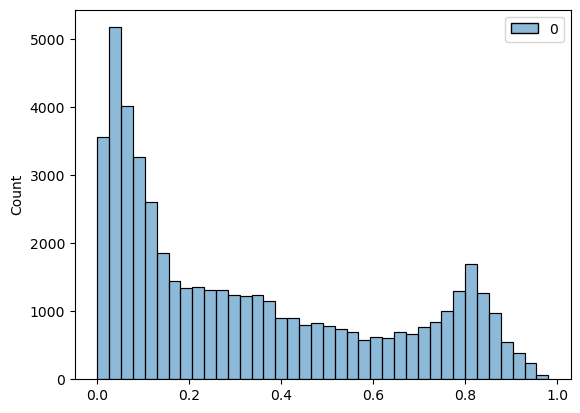

In [57]:
sns.histplot(Xpred)

In [64]:
ypred = [1 if x >= 0.5 else 0 for x in Xpred]

In [65]:
from sklearn.metrics import classification_report

In [66]:
print(classification_report(ytest, ypred, target_names=['b','s']))

              precision    recall  f1-score   support

           b       0.84      0.91      0.87     32884
           s       0.80      0.66      0.72     17116

    accuracy                           0.83     50000
   macro avg       0.82      0.79      0.80     50000
weighted avg       0.82      0.83      0.82     50000

